In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, QuantileRegressor
from quantile_forest import RandomForestQuantileRegressor
import sksurv
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest, ExtraSurvivalTrees, GradientBoostingSurvivalAnalysis

In [2]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


numpy==2.1.1
pandas==2.2.3
seaborn==0.13.2
sklearn==1.5.2
sksurv==0.23.0


In [3]:
from sksurv.datasets import load_veterans_lung_cancer, load_breast_cancer, load_whas500, load_gbsg2, load_flchain

Data

In [4]:
data_x, data_y = load_whas500()
data_x_numeric = OneHotEncoder().fit_transform(data_x).to_numpy()
data_x.head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0


Censored outcome distribution

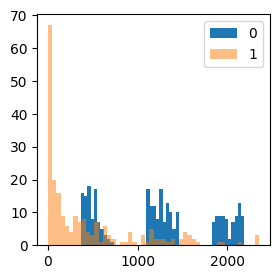

In [5]:
plt.figure(figsize=(3,3))
event, censored_outcome = zip(*data_y) 
event, censored_outcome = np.array(list(event)), np.array(list(censored_outcome))
plt.hist(censored_outcome[event==False], bins=50, label='0')
plt.hist(censored_outcome[event==True], bins=50, alpha=0.5, label='1')
plt.legend();plt.show()

Two-sided conformal procedure

In [6]:
from proc import TwoSidedCP
from scores import surv_cdf_score, quantile_based_score, reg_quantile_based_score
from misc import compute_error_bounds

In [7]:
clf_model=RandomForestClassifier()
clf_parameters_grid = {'max_depth':[2, 5, 10, None],'max_samples':[0.8, None] }
surv_model = GradientBoostingSurvivalAnalysis(n_estimators=500)
surv_parameters_grid={"estimator__learning_rate": [1e-2, 0.1, 0.2], 
                      "estimator__max_depth":np.arange(1,5,dtype=np.int32),
                      "estimator__subsample":[0.8, 1.]}
level=0.2

In [8]:
random_state=2024

#split data into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(data_x_numeric, data_y, test_size=0.2, random_state=random_state) 

meth=TwoSidedCP(X_train, Y_train, 
                alpha0=level/2, alpha1=level/2,
                                  black_box_surv =surv_cdf_score(model=surv_model), 
                                  black_box_event=clf_model, 
                                  black_box_lb =None,
                                  clf_parameters_grid=clf_parameters_grid, 
                                  surv_parameters_grid=surv_parameters_grid, 
                                  random_state=random_state)
                    
S, event_pred =meth.predict(X_test) 

Compute coverage bounds and power metrics

In [9]:
#LB and UB on true coverage
err_lo, err_up= compute_error_bounds(Y_test, S, event_pred)
cov_lo, cov_up=1-err_lo, 1-err_up
print("Coverage (lower bound, upper bound):",cov_lo, cov_up) 

Coverage (lower bound, upper bound): 0.85 0.92


Positive rate 0.29


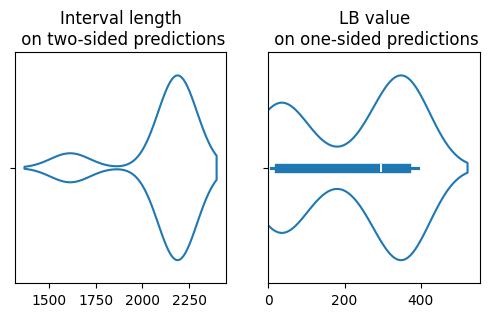

In [10]:
# Power metrics
m=len(Y_test)
lower_bounds, upper_bounds = zip(*S) 
lower_bounds, upper_bounds = np.array(lower_bounds), np.array(upper_bounds)
positives = (event_pred==1)
negatives = (event_pred==0)

# Two-sided prediction rate
positive_rate = np.sum(positives)/m 
print("Positive rate", positive_rate)

# Two-sided or one-sided interval length 
positives_length= upper_bounds[positives]-lower_bounds[positives]
negatives_length= lower_bounds[negatives]

plt.figure(figsize=(6,3))

plt.subplot(121)
sns.violinplot(x=positives_length, fill=False); plt.title("Interval length"+"\n on two-sided predictions")

plt.subplot(122)
sns.violinplot(x=negatives_length, fill=False); plt.title("LB value"+"\n on one-sided predictions")
plt.xlim(0,None)

plt.show()